# Importations

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, learning_curve, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statistical modeling
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

#Tuning
from sklearn.model_selection import GridSearchCV

# Warnings and configs
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Report Function

In [2]:
def full_report(model,X_train,y_train,X_test,y_test,model_name,rs,cv,lcv):

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    crossval_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean())
    mse_scores = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)
    crossval_rmse_std = rmse_scores.std()    
    crossval_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()
    crossval_r2_std = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').std()

    tt_dp_rmse=(test_rmse-train_rmse)/test_rmse

    tcv_dp_rmse=(crossval_rmse-test_rmse)/test_rmse

    tt_dp_r2=(train_r2-test_r2)

    tcv_dp_r2=(test_r2-crossval_r2)

    print(model_name,'(random state:',rs,')')
    print(f'Train RMSE: {train_rmse:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Crossval RMSE Mean: {crossval_rmse:.2f}')
    print(f'Crossval RMSE SD: {crossval_rmse_std:.2f}')
    print(f'Percentage Difference between Train RMSE and Test RMSE: {tt_dp_rmse:.2f}')
    print(f'Percentage Difference between Test RMSE and Crossval RMSE: {tcv_dp_rmse:.2f}')
    print(f'Train R2: {train_r2:.2f}')
    print(f'Test R2: {test_r2:.2f}')
    print(f'Crossval R2 Mean: {crossval_r2:.2f}')
    print(f'Crossval R2 SD: {crossval_r2_std:.2f}')
    print(f'Percentage Difference between Train R2 and Test R2: {tt_dp_r2:.2f}')
    print(f'Percentage Difference between Test R2 and Crossval R2: {tcv_dp_r2:.2f}')

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=lcv, scoring='neg_mean_squared_error', n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_rmse = np.sqrt(-train_scores)
    test_scores_rmse = np.sqrt(-test_scores)

    train_scores_mean = np.mean(train_scores_rmse, axis=1)
    train_scores_std = np.std(train_scores_rmse, axis=1)
    test_scores_mean = np.mean(test_scores_rmse, axis=1)
    test_scores_std = np.std(test_scores_rmse, axis=1)

    plt.figure()
    plt.title('RMSE Learning Curve for ' + model_name)
    plt.xlabel('Training Size')
    plt.ylabel('RMSE')
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    rightmost_gap = train_scores_mean[-1] - test_scores_mean[-1] 
    print(f"Rightmost Gap: {-rightmost_gap:.4f}")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()    


    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=lcv, scoring='r2', n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title('R2 Learning Curve for ' + model_name)
    plt.xlabel('Training Size')
    plt.ylabel('$R^2$ Score')
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
                     
    rightmost_gap = train_scores_mean[-1] - test_scores_mean[-1] 
    print(f"Rightmost Gap: {rightmost_gap:.4f}")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()   

# Data Loading

In [3]:
DATA_PATH = r"D:\Tradod\finalized dataset\finalized_dataset.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42

df_full = pd.read_csv(DATA_PATH)

df = df_full.copy()

df.head(10)

,file_name,province,year,num_all,num_c1,num_c2,num_c3,num_c4,num_c5,TV_S,TV_D,TV_O,A_S,temperature,rain,death
0,10-gharbi-1402,West Azerbaijan,1402,158676557,143988708,4212748,4080667,940300,5454134,11863639,11743768,1910596,76.435353,14.8,125.4,547
1,11-tehran-1400,Tehran,1400,853881003,790501679,32233500,11354258,7649788,12141778,90660358,200425016,422068,75.844029,17.8,182.2,405
2,11-yazd-1402,Yazd,1402,150082607,106646487,8115591,8468633,4819321,22032575,13465812,1865145,1815844,74.190094,20.6,84.2,190
3,11-zanjan-1402,Zanjan,1402,173125367,139241504,10692582,7070169,1848894,14272218,24901686,26151568,213343,72.975047,13.1,244.7,225
4,8-gilan-1403,Gilan,1403,204853185,176500206,15692424,2923832,1622469,8114254,5670114,13381898,776368,63.561433,17.8,1197.2,348
5,alborz-1395,Alborz,1395,492768581,444467578,22836036,7477670,7076848,10910449,51254930,96977037,937695,69.904311,17.2,242.3,180
6,alborz-1396,Alborz,1396,515748213,466775950,21700373,8979560,9423573,8868757,47331086,112896705,988281,67.802532,17.2,225.9,145
7,alborz-1397,Alborz,1397,534003291,490011336,16990789,8245891,9097411,9657864,41253161,120978996,958915,65.739903,17.6,203.4,182
8,alborz-1398,Alborz,1398,505759374,470872177,11043247,5974327,8185359,9684264,34216876,112732269,758237,65.848025,17.5,157.8,172
9,alborz-1399,Alborz,1399,422717481,392195987,11302875,5798356,5099122,8321141,31036762,83927866,700800,65.119208,19.0,118.9,181


In [4]:
df.shape

(279, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    279 non-null    object 
 1   province     279 non-null    object 
 2   year         279 non-null    int64  
 3   num_all      279 non-null    int64  
 4   num_c1       279 non-null    int64  
 5   num_c2       279 non-null    int64  
 6   num_c3       279 non-null    int64  
 7   num_c4       279 non-null    int64  
 8   num_c5       279 non-null    int64  
 9   TV_S         279 non-null    int64  
 10  TV_D         279 non-null    int64  
 11  TV_O         279 non-null    int64  
 12  A_S          279 non-null    float64
 13  temperature  279 non-null    float64
 14  rain         279 non-null    float64
 15  death        279 non-null    int64  
dtypes: float64(3), int64(11), object(2)
memory usage: 35.0+ KB


In [6]:
df[['province']].value_counts()

province                  
Alborz                        9
Kordestan                     9
Yazd                          9
West Azerbaijan               9
Tehran                        9
South Khorasan                9
Sistan and Baluchestan        9
Semnan                        9
Razavi Khorasan               9
Qom                           9
Qazvin                        9
North Khorasan                9
Mazandaran                    9
Markazi                       9
Lorestan                      9
Kohgiluyeh and Boyer-Ahmad    9
Ardabil                       9
Khuzestan                     9
Kermanshah                    9
Kerman                        9
Isfahan                       9
Ilam                          9
Hormozgan                     9
Hamedan                       9
Golestan                      9
Gilan                         9
Fars                          9
East Azerbaijan               9
Chaharmahal and Bakhtiari     9
Bushehr                       9
Zanjan       

In [7]:
df[['year']].value_counts()

year
1395    31
1396    31
1397    31
1398    31
1399    31
1400    31
1401    31
1402    31
1403    31
Name: count, dtype: int64

In [8]:
df = df.drop([0, 1, 2, 3, 4]) 
df = df[df['year'] != 1403]

In [9]:
df.head(10)

,file_name,province,year,num_all,num_c1,num_c2,num_c3,num_c4,num_c5,TV_S,TV_D,TV_O,A_S,temperature,rain,death
5,alborz-1395,Alborz,1395,492768581,444467578,22836036,7477670,7076848,10910449,51254930,96977037,937695,69.904311,17.2,242.3,180
6,alborz-1396,Alborz,1396,515748213,466775950,21700373,8979560,9423573,8868757,47331086,112896705,988281,67.802532,17.2,225.9,145
7,alborz-1397,Alborz,1397,534003291,490011336,16990789,8245891,9097411,9657864,41253161,120978996,958915,65.739903,17.6,203.4,182
8,alborz-1398,Alborz,1398,505759374,470872177,11043247,5974327,8185359,9684264,34216876,112732269,758237,65.848025,17.5,157.8,172
9,alborz-1399,Alborz,1399,422717481,392195987,11302875,5798356,5099122,8321141,31036762,83927866,700800,65.119208,19.0,118.9,181
10,alborz-1400,Alborz,1400,489035861,457183881,12586779,6182907,6116117,6966177,33535694,104818700,694692,69.096538,18.9,215.5,206
11,alborz-1401,Alborz,1401,546653192,515862848,12136249,6038162,6550848,6065085,32732308,152025155,1226166,67.938236,19.3,225.7,246
12,alborz-1402,Alborz,1402,551128208,518338894,12508203,5852075,8041547,6387489,38810481,140411579,630253,68.579854,17.9,160.3,207
14,ardabil-1395,Ardabil,1395,73032446,64796136,2609347,2773844,856396,1996723,3779076,9287500,1159638,66.195834,10.3,273.0,126
15,ardabil-1396,Ardabil,1396,86614565,77562755,3178854,2875056,975843,2022057,6229218,12306086,1205887,70.631552,10.6,247.4,114


# X & Y Split

In [10]:
feature_cols = ['num_c1','num_c2','num_c3','num_c4','num_c5','TV_S','TV_D','TV_O','A_S','temperature','rain','province','year']
target_col = 'death'

x = df[feature_cols]
y = df[[target_col]]

# Encoding 

In [11]:
from sklearn.preprocessing import OrdinalEncoder

x = pd.get_dummies(x, columns=['year'], drop_first=False)

province_encoder = OrdinalEncoder()
x['province'] = province_encoder.fit_transform(x[['province']])

In [12]:
x.head(3)

,num_c1,num_c2,num_c3,num_c4,num_c5,TV_S,TV_D,TV_O,A_S,temperature,rain,province,year_1395,year_1396,year_1397,year_1398,year_1399,year_1400,year_1401,year_1402
5,444467578,22836036,7477670,7076848,10910449,51254930,96977037,937695,69.904311,17.2,242.3,0.0,True,False,False,False,False,False,False,False
6,466775950,21700373,8979560,9423573,8868757,47331086,112896705,988281,67.802532,17.2,225.9,0.0,False,True,False,False,False,False,False,False
7,490011336,16990789,8245891,9097411,9657864,41253161,120978996,958915,65.739903,17.6,203.4,0.0,False,False,True,False,False,False,False,False


# Train & Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Outliers

In [14]:
# No need

# Multicollinearity

In [15]:
# No need

# Fitting GradientBoostingRegressor

In [21]:
%%time
# ---------------------- Param Grid ----------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'loss': ['squared_error', 'absolute_error', 'huber']
}

# ---------------------- Repeated Nested CV + Filtering ----------------------
random_seeds = [42, 52, 62, 72, 82]
results = []

for seed in random_seeds:
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=seed)

    nested_r2_scores = []
    nested_mse_scores = []
    best_params_in_seed = []

    for train_idx, val_idx in outer_cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        grid = GridSearchCV(
            estimator=GradientBoostingRegressor(random_state=seed),
            param_grid=param_grid,
            cv=inner_cv,
            scoring='r2',
            n_jobs=-1
        )

        grid.fit(X_tr, y_tr.values.ravel())
        best_model = grid.best_estimator_
        best_params_in_seed.append(grid.best_params_)

        y_pred_val = best_model.predict(X_val)
        nested_r2_scores.append(r2_score(y_val, y_pred_val))
        nested_mse_scores.append(mean_squared_error(y_val, y_pred_val))

    mean_r2 = np.mean(nested_r2_scores)
    std_r2 = np.std(nested_r2_scores)
    mean_rmse = np.sqrt(np.mean(nested_mse_scores))

    # ---------- FILTER ----------
    accepted = (mean_r2 - std_r2) >= 0.40

    best_index = np.argmax(nested_r2_scores)
    final_params = best_params_in_seed[best_index]

    final_model = GradientBoostingRegressor(**final_params, random_state=seed)
    final_model.fit(X_train, y_train)

    y_pred_test = final_model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))


    results.append({
        'Seed': seed,
        'Mean_R2': mean_r2,
        'Std_R2': std_r2,
        'Accepted': accepted,
        'Test_R2': r2_test,
        'Test_RMSE': rmse_test,
        'Best_Hyperparams': final_params
    })

# ---------------------- Summary Table ----------------------
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)  

print("\nFiltered Model Summary Across Seeds:\n")
print(results_df)


Filtered Model Summary Across Seeds:

   Seed   Mean_R2    Std_R2  Accepted   Test_R2  Test_RMSE  \
0    42  0.578433  0.094408      True  0.827696  82.391182   
1    52  0.630072  0.055024      True  0.795732  89.708550   
2    62  0.576046  0.161377      True  0.851747  76.425021   
3    72  0.630152  0.100601      True  0.808401  86.882096   
4    82  0.637193  0.109924      True  0.786560  91.700424   

                                                                                                                                                                Best_Hyperparams  
0          {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.6}  
1  {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 1.0}  
2  {'learning_rate': 0.1, 'loss': 'squared_error', 

GradientBoostingRegressor (random state: 42 )
Train RMSE: 15.0368
Test RMSE: 80.7880
Crossval RMSE Mean: 141.88
Crossval RMSE SD: 31.20
Percentage Difference between Train RMSE and Test RMSE: 0.81
Percentage Difference between Test RMSE and Crossval RMSE: 0.76
Train R2: 1.00
Test R2: 0.83
Crossval R2 Mean: 0.60
Crossval R2 SD: 0.14
Percentage Difference between Train R2 and Test R2: 0.16
Percentage Difference between Test R2 and Crossval R2: 0.24
Rightmost Gap: 127.1081


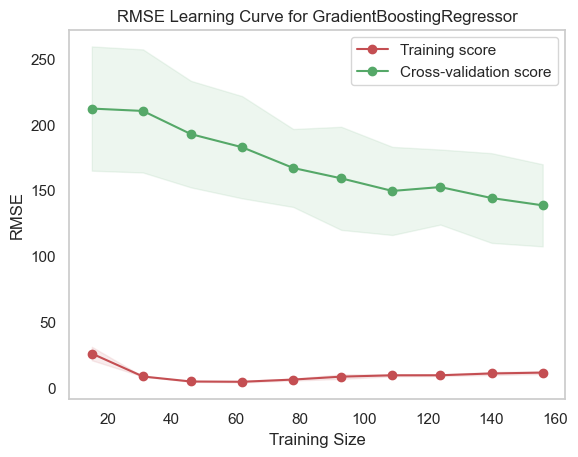

Rightmost Gap: 0.4000


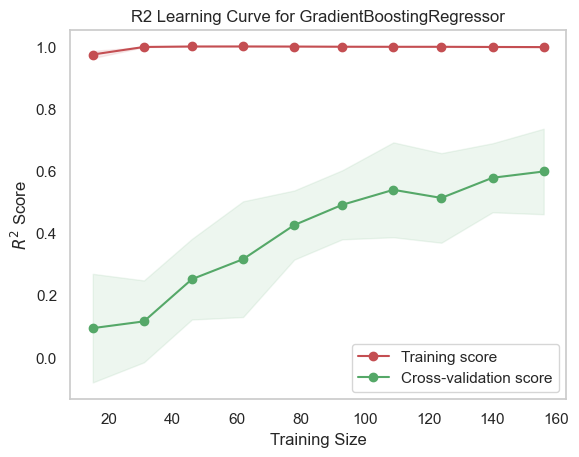

In [16]:
model=GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=300, learning_rate=0.1, max_depth=3, max_features='sqrt', min_samples_split=2, min_samples_leaf=4, subsample=0.6, loss='squared_error')
full_report(model,X_train,y_train,X_test,y_test,'GradientBoostingRegressor',RANDOM_STATE,5,5)

In [17]:
from sklearn.utils import resample

n_iterations = 1000
r2_scores = []
rmse_scores = []

final_model=model

for i in range(n_iterations):
    X_sample, y_sample = resample(X_test, y_test, replace=True, random_state=42+i)
    y_pred = final_model.predict(X_sample)
    
    r2_scores.append(r2_score(y_sample, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_sample, y_pred)))

r2_mean = np.mean(r2_scores)
r2_ci = np.percentile(r2_scores, [2.5, 97.5])

rmse_mean = np.mean(rmse_scores)
rmse_ci = np.percentile(rmse_scores, [2.5, 97.5])

print(f"R²: {r2_mean:.3f}, 95% CI: [{r2_ci[0]:.3f}, {r2_ci[1]:.3f}]")
print(f"RMSE: {rmse_mean:.2f}, 95% CI: [{rmse_ci[0]:.2f}, {rmse_ci[1]:.2f}]")

R²: 0.827, 95% CI: [0.736, 0.881]
RMSE: 80.41, 95% CI: [64.10, 97.37]


GradientBoostingRegressor (random state: 42 )
Train RMSE: 103.7711
Test RMSE: 105.0112
Crossval RMSE Mean: 160.77
Crossval RMSE SD: 36.04
Percentage Difference between Train RMSE and Test RMSE: 0.01
Percentage Difference between Test RMSE and Crossval RMSE: 0.53
Train R2: 0.80
Test R2: 0.72
Crossval R2 Mean: 0.50
Crossval R2 SD: 0.12
Percentage Difference between Train R2 and Test R2: 0.08
Percentage Difference between Test R2 and Crossval R2: 0.22
Rightmost Gap: 54.6242


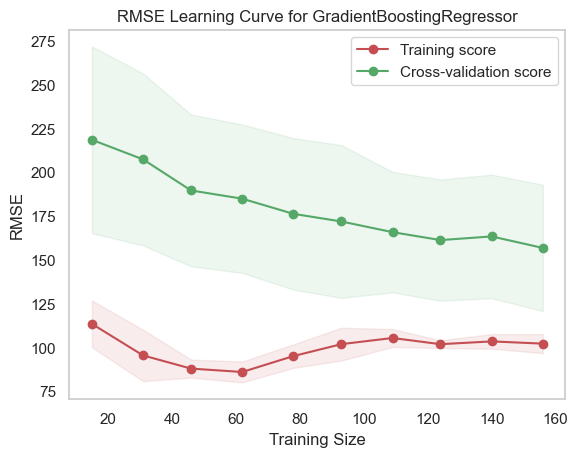

Rightmost Gap: 0.3022


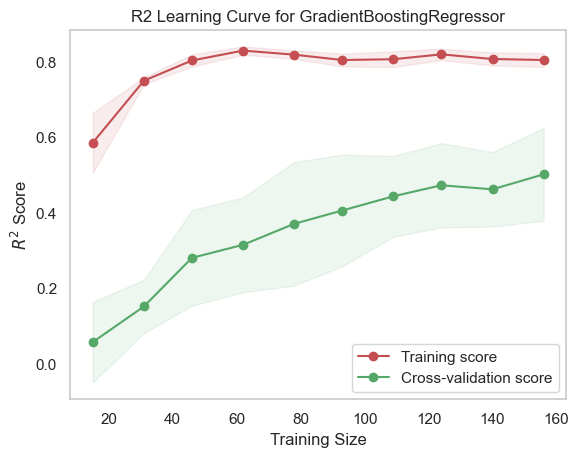

In [19]:
# CHANGE: learning_rate=0.011
model=GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=300, learning_rate=0.011, max_depth=3, max_features='sqrt', min_samples_split=2, min_samples_leaf=4, subsample=0.6, loss='squared_error')
full_report(model,X_train,y_train,X_test,y_test,'GradientBoostingRegressor',RANDOM_STATE,5,5)

In [20]:
from sklearn.utils import resample

n_iterations = 1000
r2_scores = []
rmse_scores = []

final_model=model

for i in range(n_iterations):
    X_sample, y_sample = resample(X_test, y_test, replace=True, random_state=42+i)
    y_pred = final_model.predict(X_sample)
    
    r2_scores.append(r2_score(y_sample, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_sample, y_pred)))

r2_mean = np.mean(r2_scores)
r2_ci = np.percentile(r2_scores, [2.5, 97.5])

rmse_mean = np.mean(rmse_scores)
rmse_ci = np.percentile(rmse_scores, [2.5, 97.5])

print(f"R²: {r2_mean:.3f}, 95% CI: [{r2_ci[0]:.3f}, {r2_ci[1]:.3f}]")
print(f"RMSE: {rmse_mean:.2f}, 95% CI: [{rmse_ci[0]:.2f}, {rmse_ci[1]:.2f}]")

R²: 0.714, 95% CI: [0.599, 0.821]
RMSE: 103.96, 95% CI: [73.73, 136.68]


In [24]:
%%time
# ---------------------- Param Grid ----------------------
param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.011],
    'max_depth': [3],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt'],
    'loss': ['squared_error']
}

# ---------------------- Repeated Nested CV + Filtering ----------------------
random_seeds = [42, 52, 62, 72, 82]
results = []

for seed in random_seeds:
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=seed)

    nested_r2_scores = []
    nested_mse_scores = []
    best_params_in_seed = []

    for train_idx, val_idx in outer_cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        grid = GridSearchCV(
            estimator=GradientBoostingRegressor(random_state=seed),
            param_grid=param_grid,
            cv=inner_cv,
            scoring='r2',
            n_jobs=-1
        )

        grid.fit(X_tr, y_tr.values.ravel())
        best_model = grid.best_estimator_
        best_params_in_seed.append(grid.best_params_)

        y_pred_val = best_model.predict(X_val)
        nested_r2_scores.append(r2_score(y_val, y_pred_val))
        nested_mse_scores.append(mean_squared_error(y_val, y_pred_val))

    mean_r2 = np.mean(nested_r2_scores)
    std_r2 = np.std(nested_r2_scores)
    mean_rmse = np.sqrt(np.mean(nested_mse_scores))

    # ---------- FILTER ----------
    accepted = (mean_r2 - std_r2) >= 0.40

    best_index = np.argmax(nested_r2_scores)
    final_params = best_params_in_seed[best_index]

    final_model = GradientBoostingRegressor(**final_params, random_state=seed)
    final_model.fit(X_train, y_train)

    y_pred_test = final_model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))


    results.append({
        'Seed': seed,
        'Mean_R2': mean_r2,
        'Std_R2': std_r2,
        'Accepted': accepted,
        'Test_R2': r2_test,
        'Test_RMSE': rmse_test,
        'Best_Hyperparams': final_params
    })

# ---------------------- Summary Table ----------------------
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)  

print("\nFiltered Model Summary Across Seeds:\n")
print(results_df)


Filtered Model Summary Across Seeds:

   Seed   Mean_R2    Std_R2  Accepted   Test_R2   Test_RMSE  \
0    42  0.484119  0.080854      True  0.684703  111.453378   
1    52  0.479351  0.075428      True  0.663874  115.075879   
2    62  0.436761  0.087138     False  0.708088  107.240622   
3    72  0.534771  0.099534      True  0.675576  113.055001   
4    82  0.484783  0.085379     False  0.673485  113.418824   

                                                                                                                                                                 Best_Hyperparams  
0  {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}  
1  {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 1.0}  
2  {'learning_rate': 0.01, 'loss': 'square

In [25]:
print('Train Y Mean:',y_train.mean().values[0])
print('Train Y STD:',y_train.std().values[0])
print('Test Y Mean:',y_test.mean().values[0])
print('Test Y STD:',y_test.std().values[0])

Train Y Mean: 378.37948717948717
Train Y STD: 231.76463262948468
Test Y Mean: 351.2244897959184
Test Y STD: 200.54449478296607
